In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
pd.plotting.register_matplotlib_converters()

dfo = pd.read_pickle("data/short/pickle")
dfo = dfo.dropna()
dfo['function_stop'] = pd.to_datetime(dfo['function_stop'], unit='s')
dfo['function_start'] = pd.to_datetime(dfo['function_start'], unit='s')
dfo = dfo.set_index("function_start").sort_index()
dfo['invoke_start'] = pd.to_datetime(dfo['invoke_time'], unit='s')
dfo['return_stop'] = pd.to_datetime(dfo['return_time'], unit='s')
dfo["isCold"] = dfo["isCold"].map({'True': True, 'False': False})

In [2]:
df = dfo.copy()#.sample(frac=0.5, replace=True, random_state=1)


In [3]:
%%capture
df["wrongCold"] = ((df["type"] == "Warm") & (df["isCold"]))

df["internal_time"] = df["function_stop"] - df.index
df["external_time"] = df["return_stop"] - df["invoke_start"]
df["test"] = df["func_name"].str.split(pat="_").str[0]

null_ts = df['invoke_start'].min()
df["function_start_norm"] = df.index - null_ts
df["hours_since_start"] = df["function_start_norm"].dt.total_seconds() / 3600
df["dow"] = df.index.day_of_week
df["hod"] = df.index.hour
df["how"] = (df["dow"] * 24) + df["hod"] 

In [4]:
float = df.loc[df["test"] == "float"]
matrix = df.loc[df["test"] == "matrix"]
ml = df.loc[df["test"] == "ml"]

all128 = df.loc[df["size"] == 128]

case = float
onlyCold = case.loc[case["isCold"]]
onlyCold128 = onlyCold.loc[onlyCold["size"] == 128]
onlyWarm = case.loc[case["isCold"] == False]
onlyWarm128 = onlyWarm.loc[onlyWarm["size"] == 128]
onlyWarm256 = onlyWarm.loc[onlyWarm["size"] == 256]
onlyWarm512 = onlyWarm.loc[onlyWarm["size"] == 512]

In [5]:
ml["size"].unique()

array([ 512, 1024])

<Axes: xlabel='how', ylabel='google_time'>

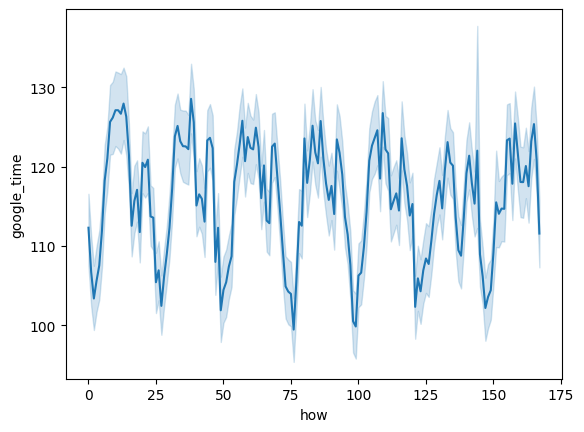

In [6]:
sns.lineplot(data=onlyWarm128, y="google_time", x="how")

<Axes: xlabel='dow', ylabel='google_time'>

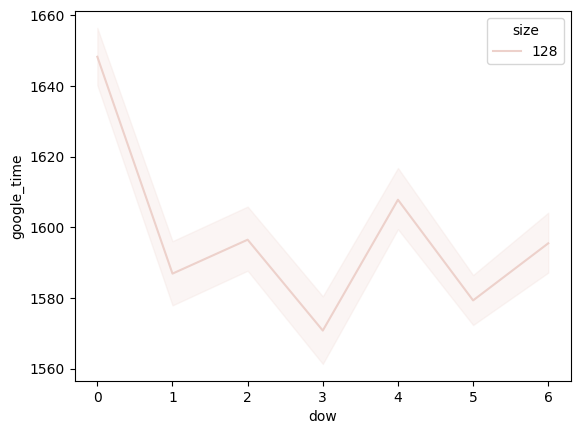

In [7]:
sns.lineplot(data=onlyCold128, y="google_time", x="dow", hue="size")

In [8]:
onlyWarm128["internal_time"].dt.total_seconds().mean()

0.07428313183140484

In [9]:
onlyWarm128["google_time"].mean()

115.7010617293149

<Axes: xlabel='hod', ylabel='google_time'>

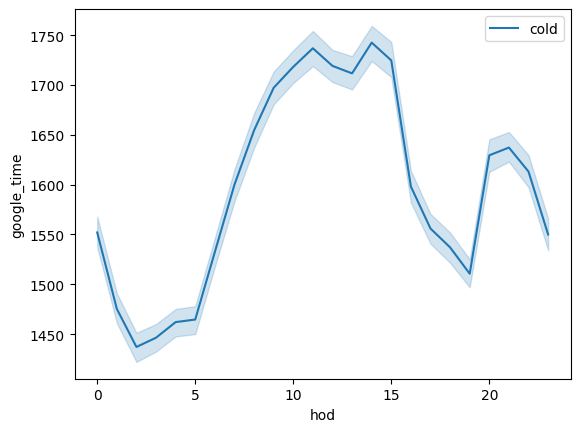

In [10]:
sns.lineplot(data=onlyCold128, y="google_time", x="hod", label="cold")

<Axes: xlabel='how', ylabel='internal_time'>

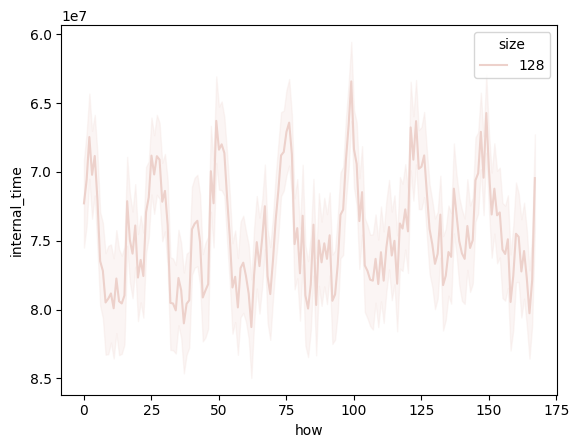

In [11]:
sns.lineplot(data=onlyWarm128, y="internal_time", x="how", hue="size")

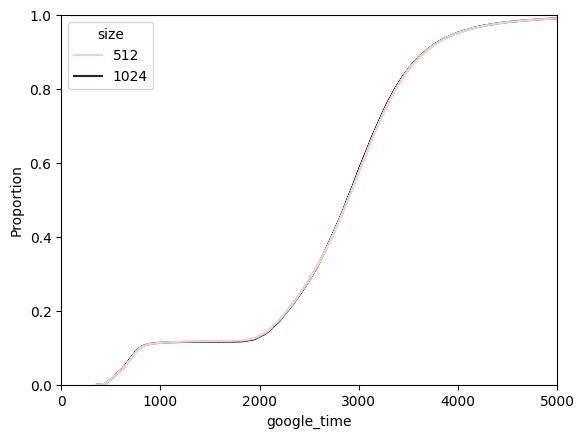

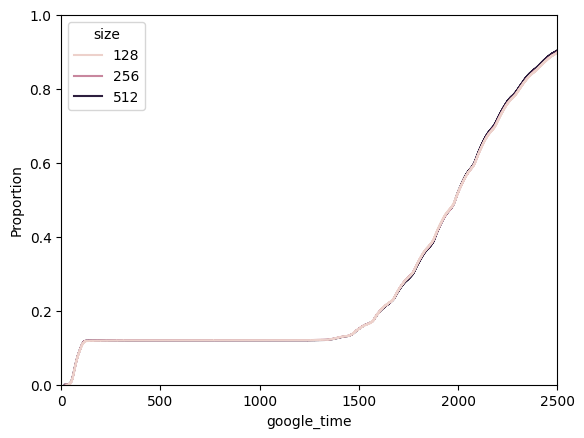

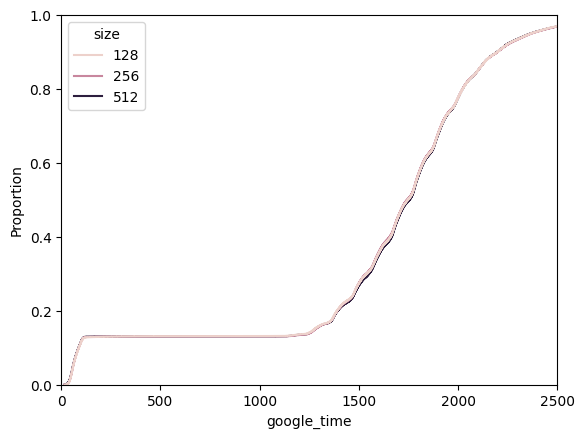

[None, None, None]

In [12]:
def ecdfMem(input, isCold):
    sns.ecdfplot(input[0].loc[input[0]["isCold"] == isCold], x="google_time", hue="size")
    plt.xlim(0, input[1])
    plt.show()
#[ecdfMem(d, False) for d in [(ml, 1000), (matrix, 350), (float, 350)]]
#[ecdfMem(d, True) for d in [(ml, 4000), (matrix, 3000), (float, 3000)]]
#[ecdfMem(d, False) for d in [(ml, 1e-9), (matrix, 1e-8), (float, 1e-8)]]
[ecdfMem(d, True) for d in [(ml, 5000), (matrix, 2500), (float, 2500)]]

<Axes: xlabel='hod', ylabel='google_time'>

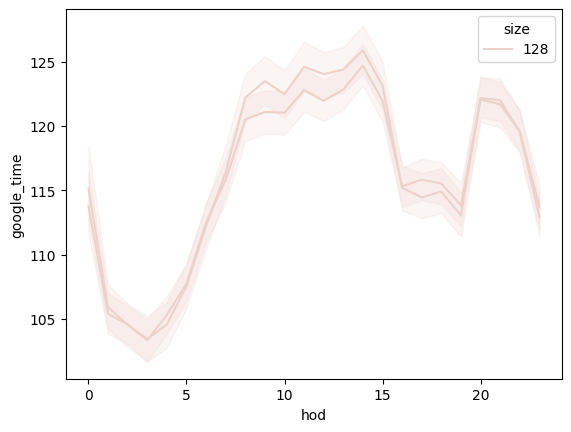

In [13]:
# Show the performance increase on 6.2.23
# Its not really noticeable this way
ax = sns.lineplot(data=onlyWarm128, y="google_time", x="hod", hue="size", legend=None)
#only_special = onlyWarm.loc[pd.Timestamp("2023-2-6T00:00:00") : pd.Timestamp("2023-2-6T23:59:59")]
#sns.lineplot(ax=ax, data=only_special, y="google_time", x="hod", hue="size")

#only_later = onlyWarm.loc[pd.Timestamp("2023-2-6T23:59:59") : pd.Timestamp("2025-2-1T23:59:59")]
#sns.lineplot(ax=ax, data=only_later, y="google_time", x="hod", hue="size", legend=None)

only_before = onlyWarm128.loc[pd.Timestamp("2000-2-6T00:00:00") : pd.Timestamp("2023-2-6T23:59:59")]
sns.lineplot(ax=ax, data=only_before, y="google_time", hue="size", x="hod")

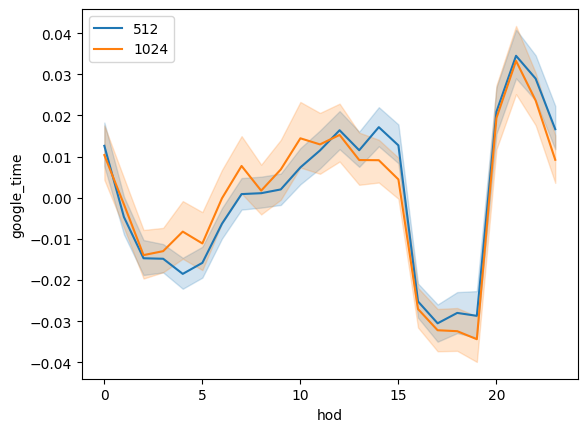

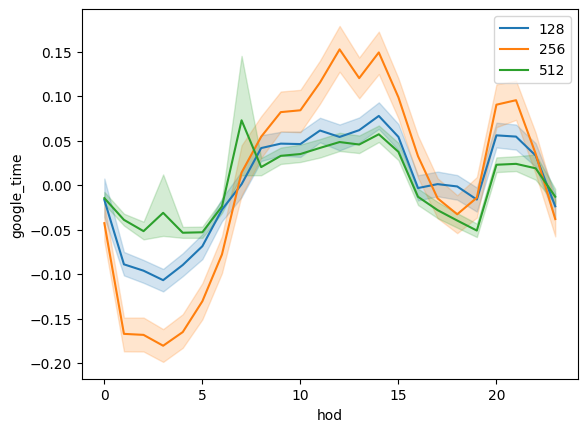

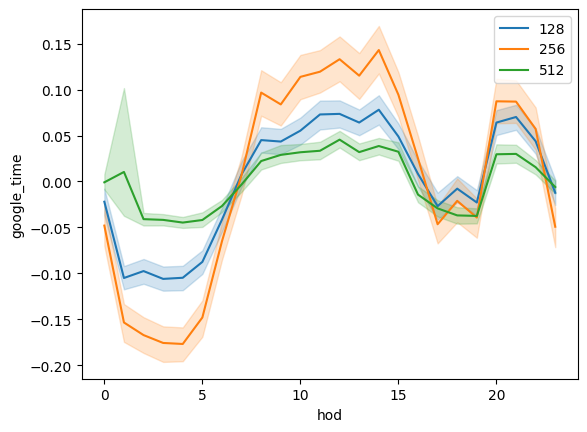

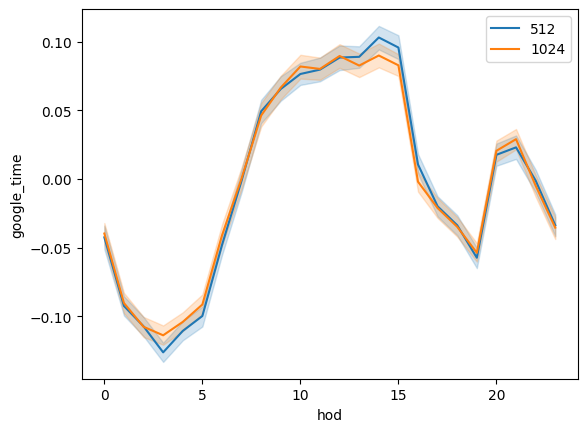

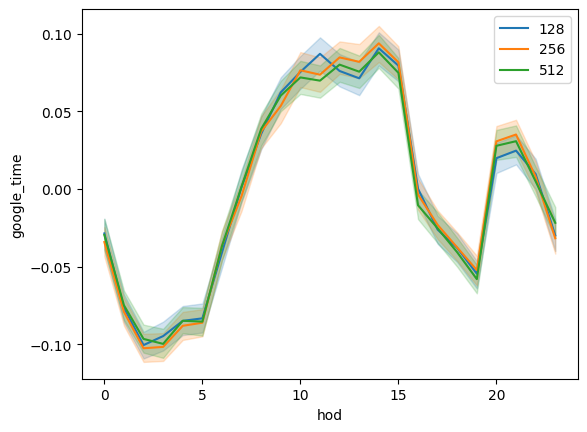

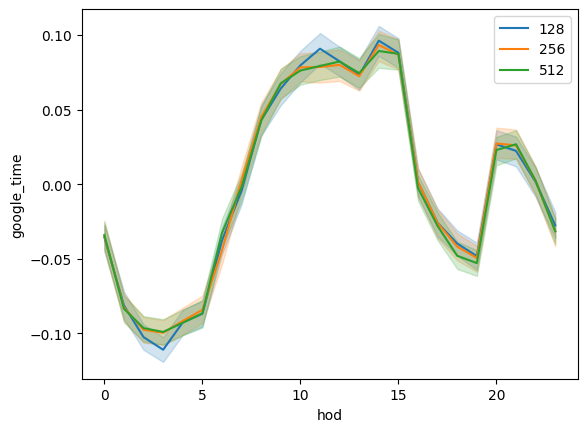

[None, None, None]

In [14]:
# Memory Size Impact on Performance
def showMemImpact(input, isCold):
    msi = input.loc[input["isCold"] == isCold]
    msi["size"].unique()
    fSize = {s: msi.loc[msi["size"] == s] for s in sorted(msi["size"].unique())}
    #averages = [{ s: msi.loc[msi["size"] == s].mean() } for s in msi["size"].unique()]
    #averages

    for elem in fSize.keys():
        df = fSize[elem]
        mean = df["google_time"].mean()
        sns.lineplot(df, x="hod", y=(df["google_time"] - mean)/mean, label=elem)
    plt.show()



[showMemImpact(uc, False) for uc in [ml, float, matrix]]
[showMemImpact(uc, True) for uc in [ml, float, matrix]]

In [15]:
sorted(float["size"].unique())

[128, 256, 512]

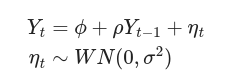

T-ter Wert ist Konstante + Faktor * letzter Wert + error (normalverteilt um 0)

ARMA == Auto Regression Moving Average
AR = wie viele vorherige werte (+gewicht) werden genommen (y_t-1)
MA = Wie viel wird die Änderung aus der letzten Perioden eingenommenimage.png (theta * epsilon)

ARIMA = Integrated... ==> Nichtstationnäre Sachen. Brauche ich wahrscheinlich nicht, weil meine Sachen ja nicht wegrennen. Man kann ja aber I ruhig 0 setzen und das andere mal testen

Autokorrelation sagt einem, dass die Autokorrelation im vergleich mit N wert vorher signifikant ist

Schritt 1 ist also sich AR und MA von dem Ding einfach mal anzeigen zu lassen

..... andere Klassen von Modellen mit Bayes. Additive sesonalitätskomponenten ist einfacher

## Modellvergleich
mit AIC und BIC Information Criterion könnte man machen

Aber man sieht sehr deutlich dass 24 signifikant ist

In [16]:
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [17]:
rs_1h = onlyWarm128[["google_time"]].resample("H").mean(numeric_only=True).dropna()
#rs_1h = rs_1h[pd.to_datetime("2022-12-20"):pd.to_datetime("2024-01-15")]
#rs_1h.index = rs_1h.index.to_period("H")

In [18]:
import statsmodels.tsa.seasonal as seasonal

https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html ==> Forecasting with STL

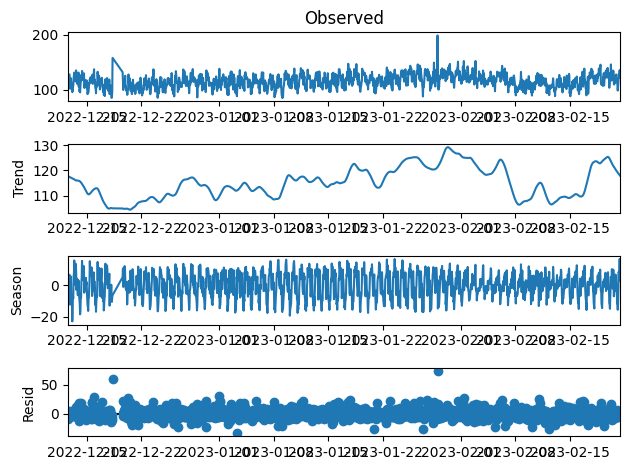

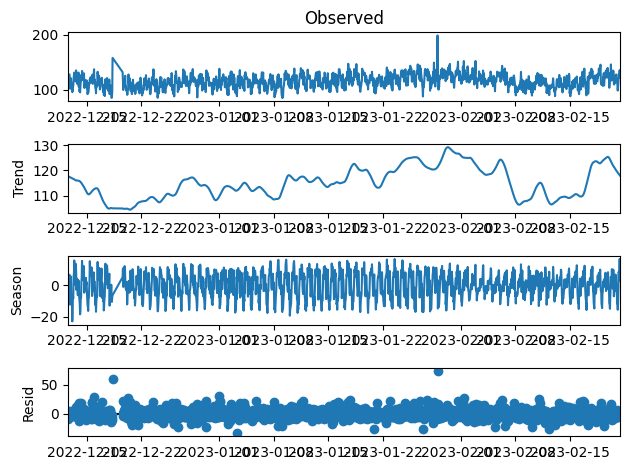

In [19]:
stl = seasonal.STL(rs_1h, period=24, robust=True)
res24 = stl.fit()
res24.plot()

In [20]:
residuals = res24.resid
Q1 = residuals.quantile(0.25)
Q3 = residuals.quantile(0.75)
IQR = Q3 - Q1
IQRF = 4

filtered = residuals.loc[(residuals > IQRF*IQR) | (residuals < -IQRF*IQR)]

function_start
2022-12-15 22:00:00    28.344602
2022-12-18 07:00:00    59.139161
2022-12-20 08:00:00    26.922581
2023-01-01 00:00:00    30.523417
2023-01-03 06:00:00   -33.036288
2023-01-27 03:00:00   -26.471604
2023-01-29 00:00:00    73.634502
2023-02-01 09:00:00    26.242627
Name: resid, dtype: float64

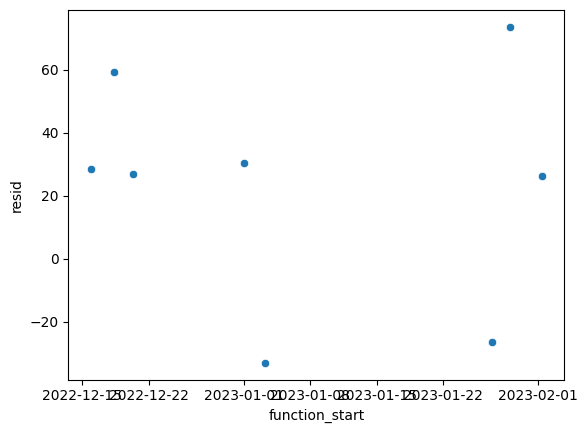

In [21]:
sns.scatterplot(filtered)
filtered

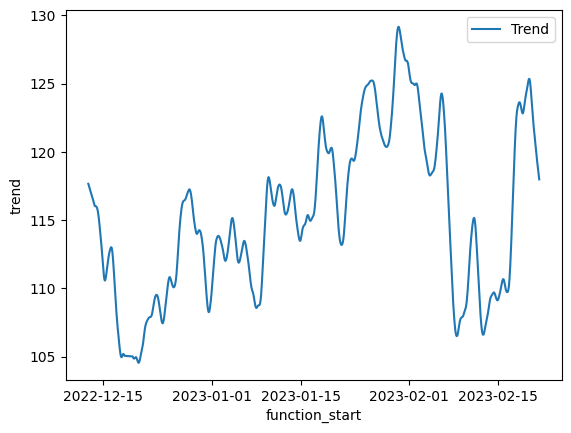

In [22]:
ax = sns.lineplot(res24.trend, label="Trend")
#ax = sns.lineplot(res24.seasonal,ax=ax, label="Season")
#ax.set_xlim("2023-01-01","2023-01-15")
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 1 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

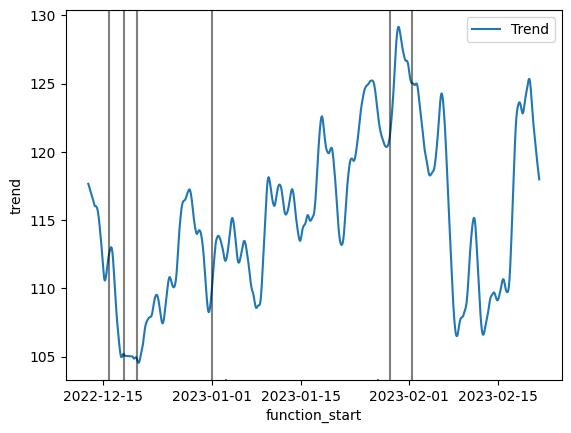

In [23]:
ax = sns.lineplot(res24.trend, label="Trend")
#ax = sns.lineplot(res24.seasonal,ax=ax, label="Season")
#ax.set_xlim("2023-01-01","2023-01-15")
for f in filtered.index:
    plt.axvline(f,0, filtered[f], alpha=0.5, color="black")
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 1 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

In [24]:
ma = rs_1h.rolling("24h", min_periods=24).mean()

In [25]:
rs_1h["ma_res"] = rs_1h["google_time"] - ma["google_time"]

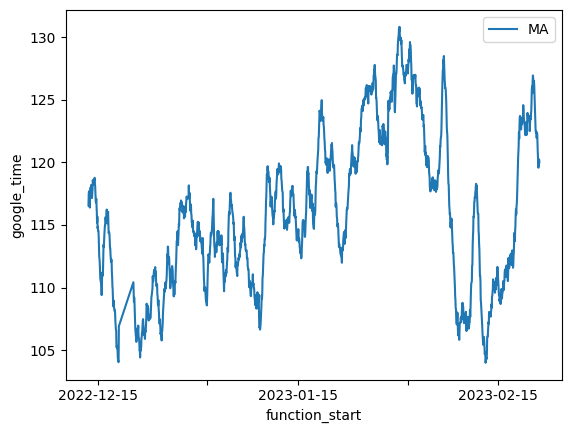

In [26]:
#sns.lineplot(data=rs_1h, y="ma_res", x=rs_1h.index, label="Res")
ax = sns.lineplot(data=ma, y="google_time", x=ma.index, label="MA")
#sns.lineplot(data=onlyWarm128, y="google_time", x=onlyWarm128.index)
#for i in filtered.index:
#    plt.axvline(i, color="green", linestyle="--")

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 2 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

In [27]:
import ruptures as rpt

signal = np.array(rs_1h["google_time"].tolist())
algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=8)

['2023-01-09T07:00:00', '2023-01-23T06:00:00', '2023-02-07T01:00:00', '2023-02-17T06:00:00', '2023-02-21T10:00:00']


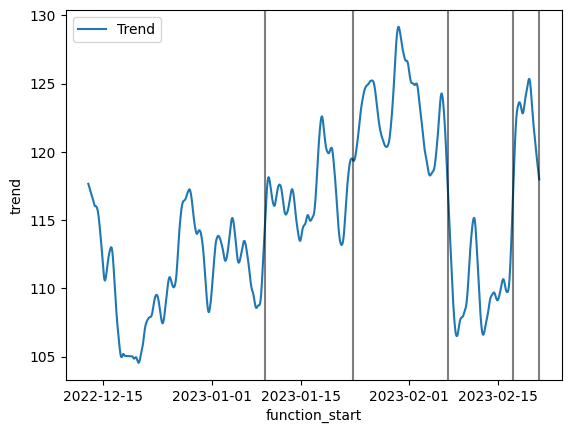

In [28]:
changePoints = []
for r in result:
    changePoints.append(rs_1h.iloc[r-1])

print([c.name.isoformat() for c in changePoints])

ax = sns.lineplot(res24.trend, label="Trend")

for p in changePoints:
    plt.axvline(p.name, alpha=0.5, color="black")
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 1 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

In [29]:
print("#Warm / #Warm + #Cold = ")

warm = df.loc[df["isCold"] == False]["invoke_id"].count()
cold = df.loc[df["isCold"] == True]["invoke_id"].count()

print(f"{str(warm)} / {str(warm)} + {str(cold)} = {warm/(warm+cold)}")

#Warm / #Warm + #Cold = 
1074187 / 1074187 + 1345434 = 0.44394845308418135


In [30]:

functions = sorted(df["func_name"].unique())

#allTests = [str(test) + '_' str(size)]

f_dict = {f: df.loc[(df["type"] == "Cold") & (df["func_name"] == f)] for f in sorted(df["func_name"].unique())}

In [31]:
lines = []
for f in f_dict.keys():
    delta = f_dict[f].shift(-1)["invoke_time"] - f_dict[f]["invoke_time"]
    mem = f_dict[f]["size"].unique()
    lines.append(f.split("_")[0] + " : " + str(mem[0]) + " : " + str(delta.mean()))

lines.sort()
print("How long between designed cold invocations between functions?")
lines

How long between designed cold invocations between functions?


['float : 128 : 203.95551231917653',
 'float : 128 : 203.96265606759698',
 'float : 128 : 203.96882597035793',
 'float : 128 : 203.9962747746301',
 'float : 128 : 204.00980505277593',
 'float : 256 : 203.91480441934922',
 'float : 256 : 203.9421083035181',
 'float : 256 : 203.96234963068812',
 'float : 256 : 204.01022256461695',
 'float : 256 : 204.03025093288664',
 'float : 512 : 204.07823107709464',
 'float : 512 : 204.0917306269713',
 'float : 512 : 204.14617041060924',
 'float : 512 : 204.15990920014167',
 'float : 512 : 204.2350244585444',
 'matrix : 128 : 201.86802193316953',
 'matrix : 128 : 201.86829846105888',
 'matrix : 128 : 201.8881839303224',
 'matrix : 128 : 201.9012125530803',
 'matrix : 128 : 201.9081379489574',
 'matrix : 256 : 201.867829534906',
 'matrix : 256 : 201.90127157467936',
 'matrix : 256 : 201.90807852154518',
 'matrix : 256 : 201.93467320387907',
 'matrix : 256 : 201.94122026808535',
 'matrix : 512 : 201.89490706075074',
 'matrix : 512 : 201.90138632616691'